In [414]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from helpers import *
from implementations import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y_train, X_train, ids = load_csv_data(DATA_TRAIN_PATH)

In [192]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [398]:
X_train_zero, y_train_zero, X_train_one, y_train_one, X_train_many, y_train_many = split_by_jet_num(DATA_TRAIN_PATH, X_train, y_train)
X_test_zero, ids_test_zero, X_test_one, ids_test_one, X_test_many, ids_test_many = split_by_jet_num(DATA_TRAIN_PATH, X_test, ids_test)

In [399]:
def train_predict(X_train, y_train, X_test, max_iters=3000, degree=2, lambda_=0.01, gamma=0.01, imputable_th=0, encodable_th=1, verbose=True):
    tX_train, ty_train, tX_test, _, cont_features = preprocess(X_train, y_train, X_test, imputable_th=imputable_th, encodable_th=encodable_th, switch_encoding=True)
    tX_train_poly = build_poly(tX_train, degree=degree, cont_features=cont_features)
    weights, loss = reg_logistic_regression(ty_train, tX_train_poly, max_iters=max_iters, lambda_=lambda_, gamma=gamma, verbose=verbose)
    tX_test_poly = build_poly(tX_test, degree=degree, cont_features=cont_features)
    y_pred = predict_logistic(weights, tX_test_poly)
    y_pred = replace_values(y_pred, from_val=0, to_val=-1)
    return y_pred, weights, loss

In [418]:
degree = 2
lambda_ = 0.01
gamma = 0.01
max_iters = 3000

In [420]:
y_pred_zero, weights_zero, loss_zero = train_predict(X_train_zero, y_train_zero, X_test_zero, max_iters=max_iters, degree=degree, lambda_=lambda_, imputable_th=0.5)

Iteration = 0, accuracy = 25.50819212715062, loss = 6.676125360328663
Iteration = 10, accuracy = 25.442134657151723, loss = 5.915264204309703
Iteration = 20, accuracy = 25.286999689730067, loss = 5.138513830792213
Iteration = 30, accuracy = 25.213936124428255, loss = 4.360392213509375
Iteration = 40, accuracy = 25.62729574730015, loss = 3.6072757405888183
Iteration = 50, accuracy = 26.719245743797103, loss = 2.918772396604958
Iteration = 60, accuracy = 29.06328505800046, loss = 2.331059760380559
Iteration = 70, accuracy = 32.615375376577624, loss = 1.8666270867684902
Iteration = 80, accuracy = 37.26642178695465, loss = 1.5219410255895904
Iteration = 90, accuracy = 42.388878324142006, loss = 1.2803102260563055
Iteration = 100, accuracy = 47.01790557785273, loss = 1.1121329957703894
Iteration = 110, accuracy = 51.26159758990322, loss = 0.9930159023291569
Iteration = 120, accuracy = 54.81568964999549, loss = 0.906905424501832
Iteration = 130, accuracy = 57.718214846916815, loss = 0.843278

ValueError: too many values to unpack (expected 2)

In [419]:
y_pred_one, weights_one, loss_one = train_predict(X_train_one, y_train_one, X_test_one, max_iters=max_iters, degree=degree, lambda_=lambda_, imputable_th=0.5)

Iteration = 0, accuracy = 35.735840297121634, loss = 6.7042836025510555
Iteration = 10, accuracy = 35.80031981842567, loss = 5.941357996868966
Iteration = 20, accuracy = 36.25812441968431, loss = 5.153737303885978
Iteration = 30, accuracy = 37.78628907458991, loss = 4.373306453039475
Iteration = 40, accuracy = 40.7304240173321, loss = 3.647741567461123
Iteration = 50, accuracy = 45.0144434127721, loss = 3.024043550341141
Iteration = 60, accuracy = 49.00443619106572, loss = 2.5281560437353745
Iteration = 70, accuracy = 52.05818632002476, loss = 2.148995657902227
Iteration = 80, accuracy = 54.42200557103064, loss = 1.8557582619438704
Iteration = 90, accuracy = 56.174558960074286, loss = 1.625575267140632
Iteration = 100, accuracy = 57.73883214691015, loss = 1.4434904010398817
Iteration = 110, accuracy = 58.87883008356546, loss = 1.2985896512872792
Iteration = 120, accuracy = 60.02140720107294, loss = 1.1837372897031362
Iteration = 130, accuracy = 61.033735685546276, loss = 1.093772447454

In [421]:
y_pred_many, weights_many, loss_many = train_predict(X_train_many, y_train_many, X_test_many, max_iters=max_iters, degree=degree, lambda_=lambda_, imputable_th=0.5)

Iteration = 0, accuracy = 44.759659787987815, loss = 5.688568427091065
Iteration = 10, accuracy = 44.89613057083385, loss = 4.863216641653588
Iteration = 20, accuracy = 45.997546282894284, loss = 4.046585844155715
Iteration = 30, accuracy = 48.458155852390995, loss = 3.309761591672408
Iteration = 40, accuracy = 51.645231104310554, loss = 2.6992515181745533
Iteration = 50, accuracy = 54.74683980535683, loss = 2.2228054322846105
Iteration = 60, accuracy = 57.290158940214766, loss = 1.8621004263991292
Iteration = 70, accuracy = 59.36616903078175, loss = 1.589836222844944
Iteration = 80, accuracy = 60.99968294666611, loss = 1.3852883702172678
Iteration = 90, accuracy = 62.28305970252126, loss = 1.2316405444754566
Iteration = 100, accuracy = 63.38585390733772, loss = 1.113930230301913
Iteration = 110, accuracy = 64.3094440538715, loss = 1.0222156521587364
Iteration = 120, accuracy = 65.19719338874874, loss = 0.950030080795351
Iteration = 130, accuracy = 66.07529327433384, loss = 0.892881028

In [422]:
y_pred = np.vstack([y_pred_zero, y_pred_one, y_pred_many])
ids_test = np.hstack([ids_test_zero, ids_test_one, ids_test_many])

In [423]:
from datetime import datetime
method = 'reg_logistic_regression_by_jet'
time = datetime.now().strftime('%Y%m%dH%H%M%S')
OUTPUT_PATH = f'../submissions/submission_{method}_{time}'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [380]:
param_grid = {
    'lambda_': np.logspace(-4, 0, 5),
    'degree': list(range(1, 4)),
    'max_iters': 100,
    'gamma': [0.01, 0.05, 0.1],
    'cont_features': [cont_features]
}
metrics, params = logistic_regression_cv(ty_train, tX_train, param_grid=param_grid)

In [381]:
metrics

{'loss': 0.5020066928657675,
 'accuracy': 75.65127676038173,
 'f1_score': 0.6365493135737614}

In [382]:
params

{'lambda_': 0.01,
 'degree': 2,
 'gamma': 0.1,
 'max_iters': 100,
 'cont_features': (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21)}

In [409]:
tX_train, ty_train, tX_test, _, cont_features = preprocess(X_train_many, y_train_many, X_test_many, imputable_th=0, encodable_th=1, switch_encoding=True)
tX_train_poly = build_poly(tX_train, degree=degree, cont_features=cont_features)
ty_train_pred = predict_logistic(weights_many, tX_train_poly)
train_accuracy = compute_accuracy(ty_train, ty_train_pred)
train_f1 = compute_f1(ty_train, ty_train_pred)
train_accuracy, train_f1

(77.89035468618613, 0.7485537805508959)

In [403]:
features = read_feature_names(DATA_TRAIN_PATH)
one_jet_features = [f for f in features if f not in ['PRI_jet_num', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet',
                                                     'DER_lep_eta_centrality', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi']]

In [410]:
features = read_feature_names(DATA_TRAIN_PATH)
many_jet_features = [f for f in features if f not in ['PRI_jet_num']]

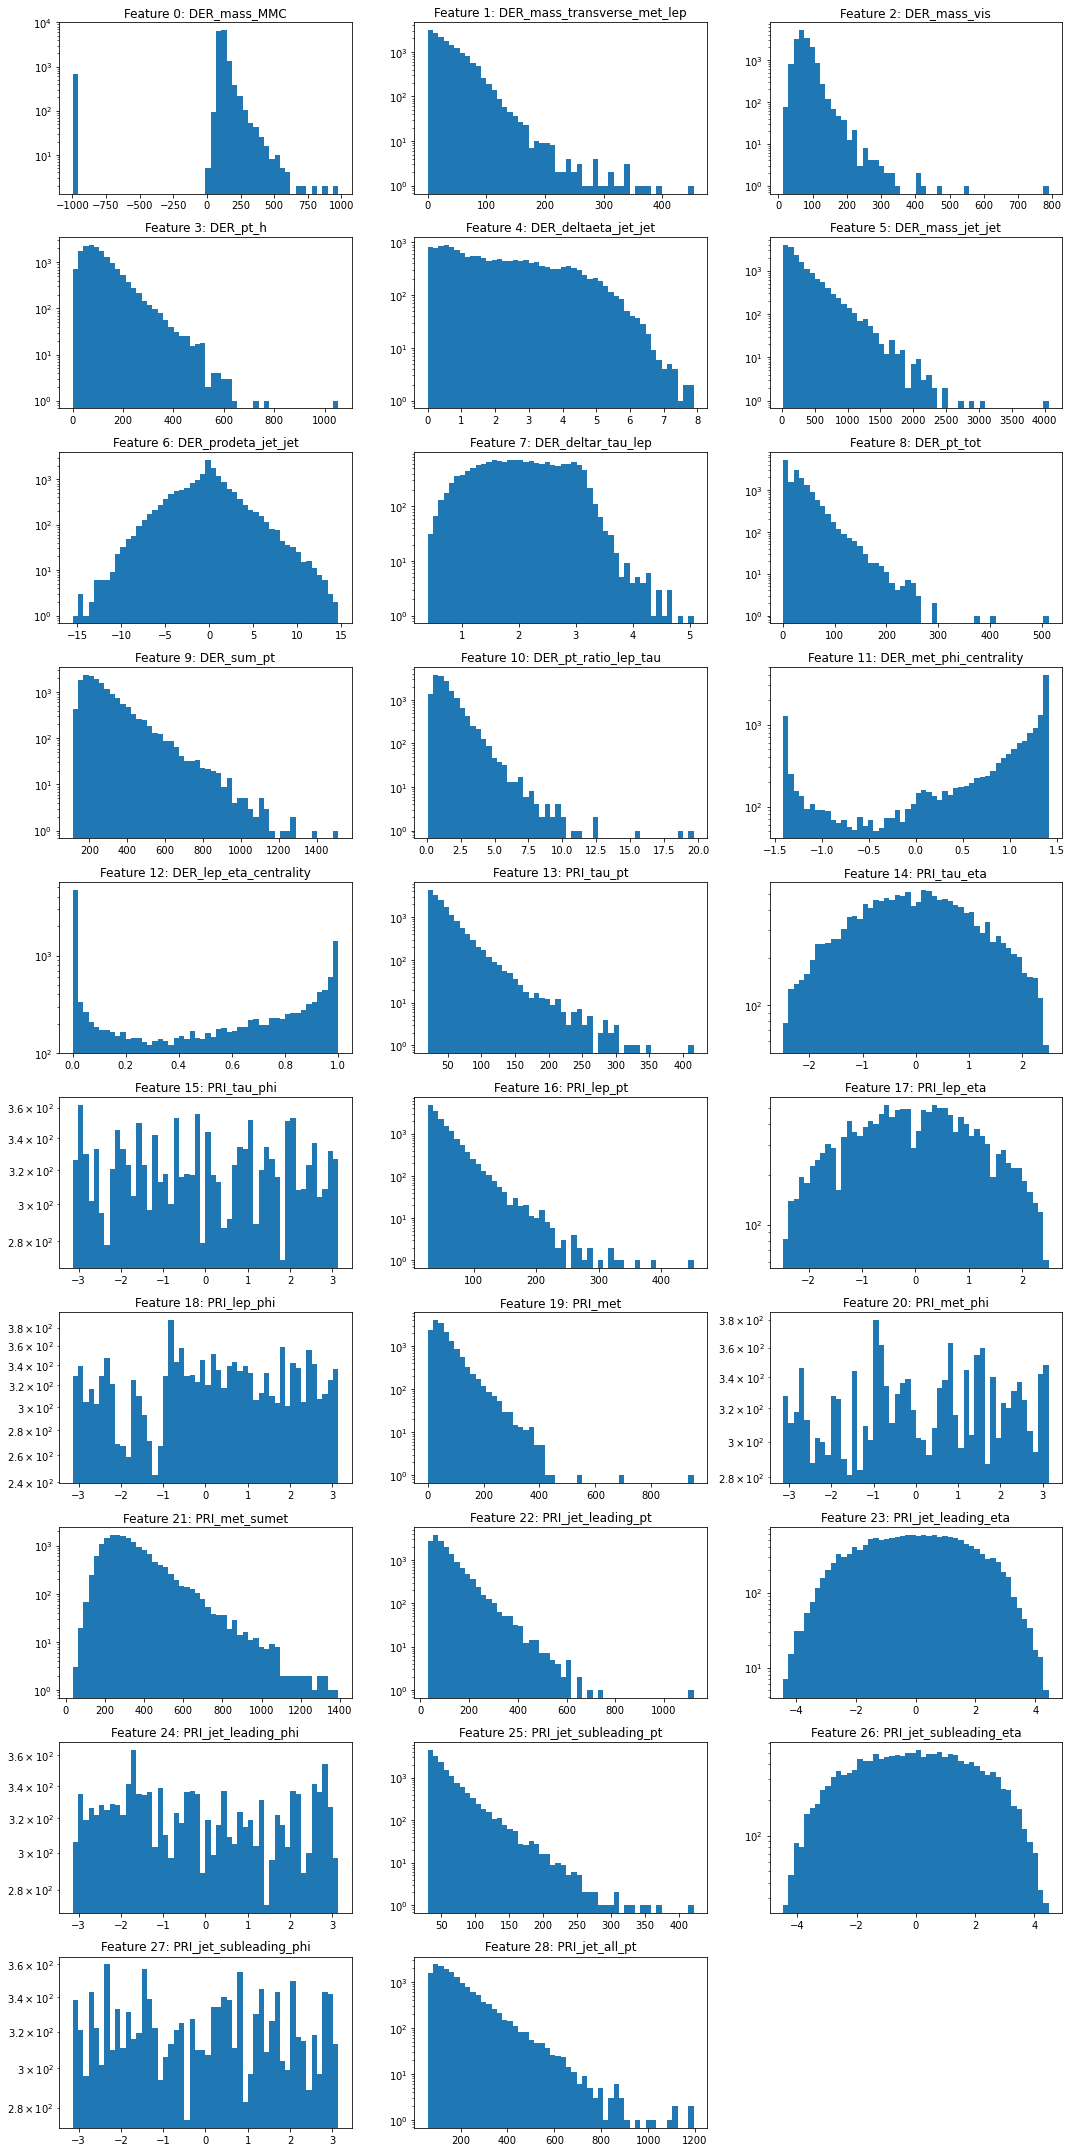

In [412]:
def plot_features_distrib(tX):
    plt.figure(figsize=(15,30))
    for i in range(tX.shape[1]):
        plt.subplot(10,3,i+1)
        plt.hist(tX[:,i], bins=50)
        plt.yscale('log')
        plt.title("Feature {}: {}".format(i, many_jet_features[i]))
    plt.tight_layout()
    plt.show();
plot_features_distrib(X_train_many[(ty_train_pred != ty_train).reshape((-1,))])

In [127]:
tX_val_poly = build_poly(tX_test, degree=params['degree'], cont_features=cont_features)
ty_val_pred = predict_logistic(weights, tX_val_poly)
val_accuracy = compute_accuracy(ty_test, ty_val_pred)
val_f1 = compute_f1(ty_test, ty_val_pred)
val_accuracy, val_f1

(78.412, 0.6540162830950702)

In [129]:
val_tmp = np.hstack([X_train_val, ty_val_pred, ty_test])

In [142]:
val_tmp_mis = val_tmp[val_tmp[:, -1] != val_tmp[:, -2]]

In [143]:
tval_tmp = replace_values(val_tmp_mis, -999, np.nan)
col_nan_ratio = compute_nan_ratio(tval_tmp)

In [144]:
col_nan_ratio

array([0.05984806, 0.        , 0.        , 0.        , 0.67129887,
       0.67129887, 0.67129887, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.67129887, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.32666296, 0.32666296,
       0.32666296, 0.67129887, 0.67129887, 0.67129887, 0.        ,
       0.        , 0.        ])

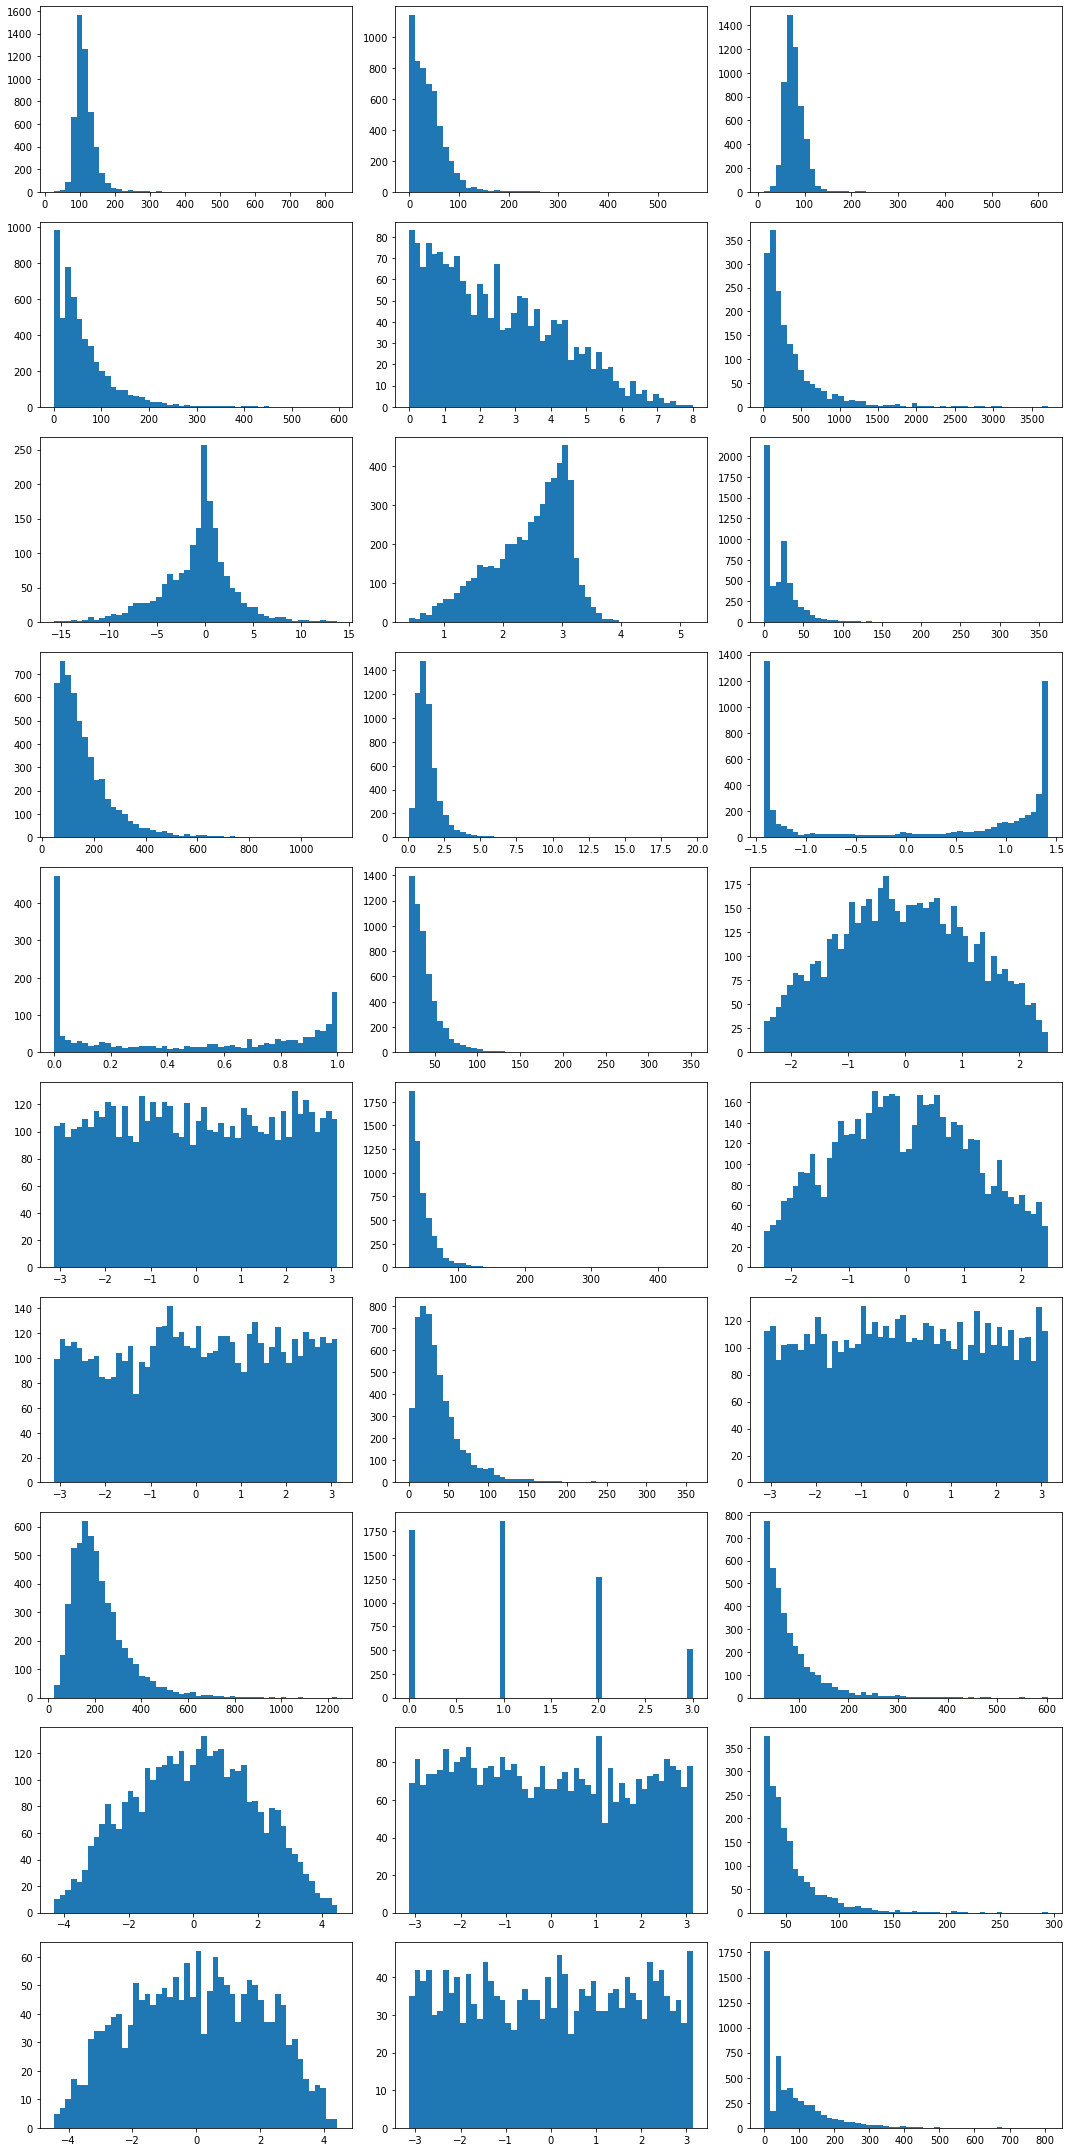

In [145]:
def plot_features_distrib(tX):
    plt.figure(figsize=(15,30))
    for i in range(tX.shape[1]):
        plt.subplot(10,3,i+1)
        plt.hist(tX[:,i], bins=50);
        # plt.title("Feature {}: {}".format(i, labels[i]))
    plt.tight_layout()
    plt.show();
plot_features_distrib(tval_tmp[:, :-2])

In [50]:
tX_test.shape

(568238, 24)

In [51]:
tX_test_poly = build_poly(tX_test, params['degree'], cont_features)

In [52]:
tX_test_poly.shape

(568238, 44)

In [365]:
from datetime import datetime
method = 'reg_logistic_regression_by_jet'
time = datetime.now().strftime('%Y%m%dH%H%M%S')
OUTPUT_PATH = f'../submissions/submission_{method}_{time}'
# y_pred = predict_logistic(weights, tX_test_poly)
# y_pred = replace_values(y_pred, from_val=0, to_val=-1)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)